# <b><center>Brain Tumor Segmentation using Deep Neural Networks</b></center>

## <b>Project Description</b>

This project is about Brain Tumor classification and segmentation using deep neural networks. It will be done in two phases:
1. In phase 1, exploratory data analysis, data preprocessing, training and validation of U-Net based CNN model will be done.
2. In phase 2, multimodal U-Net architecture will be implemented and trained to improve the accuracy. Also, we will implement some other ML models for segmentation and a comparision between them will be made.

Dataset used in this project is the <b>BraTS2020</b> dataset. This dataset is used for the <b>BraTS</b> challenge, which is an annual challenge organized by the <b>Multimodal Brain Tumor Segmentation</b> group, in order to improve the performance on brain tumor segmentation.

## <b>Importing Important Libraries</b>

In [ ]:
import keras
import cv2
import tensorflow
import random
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import pandas as pd
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.transform import rotate
from skimage.util import montage
import os
from sklearn.model_selection import train_test_split
import numpy as np
from keras.callbacks import CSVLogger
import keras.backend as K
import zipfile
from keras.applications.inception_v3 import InceptionV3
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import sklearn.metrics
from fastai.vision import *
import tensorflow as tf
from sklearn import datasets
from sklearn import preprocessing
import cv2
import xgboost as xgb
from bs4 import BeautifulSoup
from tensorflow.keras.layers import Conv2D, PReLU, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image
%matplotlib inline
from tensorflow.keras.layers import Conv2D, PReLU, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

## <b>Downloading the BraTS2020 Dataset</b>

There are two ways to get the BraTS2020 dataset:
1. From the BraTS challenge website
2. Retreive the dataset from Kaggle

In this project, we have taken the dataset via second way, i.e, from Kaggle, using API to have the dataset directly in our colab notebook environment.

Steps followed to download the dataset from Kaggle is given below:

1. Uploading the kaggle.json file on google colab. <br>
Note: kaggle.json is the file which contains the API key

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


2. Getting the location of file uploaded(kaggle.json)

In [ ]:
import os

for filename, data in uploaded.items():
    print(f"File name: {filename}")
    print(f"Temporary location: {os.path.abspath(filename)}")

File name: kaggle.json
Temporary location: /content/kaggle.json


3. Creating a root directory

In [ ]:
!mkdir ~/.kaggle

4. Getting the path of kaggle.json file

In [ ]:
import os

filename = "kaggle.json"

for root, dirs, files in os.walk('/'):
    if filename in files:
        source_path = os.path.join(root, filename)
        break

print("Source path:", source_path)

Source path: /content/kaggle.json


5. Moving the uploaded file to the root directory

In [ ]:
import shutil

destination_path = "/root/.kaggle/kaggle.json"

shutil.move(source_path, destination_path)

print("File moved successfully.")

File moved successfully.


6. Setting the API key

In [ ]:
!kaggle config set -n apikey -v ~/.kaggle/kaggle.json

- apikey is now set to: /root/.kaggle/kaggle.json


7. Downloading the dataset

In [ ]:
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

100% 4.16G/4.16G [02:23<00:00, 31.9MB/s]
100% 4.16G/4.16G [02:23<00:00, 31.2MB/s]


8. Unzipping the downloaded dataset<br>
The downloaded dataset is in zip format. So, we first need to unzip it

In [ ]:
import zipfile

# Unzip dataset
zip_path = "brats20-dataset-training-validation.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("brats20-dataset-training-validation")

9. Renaming the file name<br>
There is some issue in the naming convention of one of the files, so we need to change it

In [ ]:
name1 = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii"
name2 = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii"

try:
    os.rename(name1, name2)
    print("The file has been successfully renamed")
except FileNotFoundError:
    print("File already renamed")

The file has been successfully renamed


## <b>Exploratory Data Analysis</b>

Before data analysis, it is important to understand the structure of BraTS dataset, used for this project.

Inside the main folder("brats20-dataset-training-validation"), there are two sub-folders:
1. "BraTS2020_TrainingData"
2. "BraTS2020_ValidationData"

"BraTS2020_TrainingData" contains one sub-folder "MICCAI_BraTS2020_TrainingData" which contains 369 different sub-folders(one for each patient's MRI).

Each of those 369 different sub-folders contain 5 different files:
1. Four different types of magnetic resonance imaging (MRI) scans of their brain, also known as "modalities", which are named as T1,T1ce,T2* and *FLAIR.
2. One segmentation file, which contains segmentation result about the tumoral and non-tumoral regions of their brains, which has been manually verified by experts.



Let's see how each of these five different images look like.
<br>
Note: Each of these images are present in <b>.nii</b> format, which is a standard format for medical imaging.

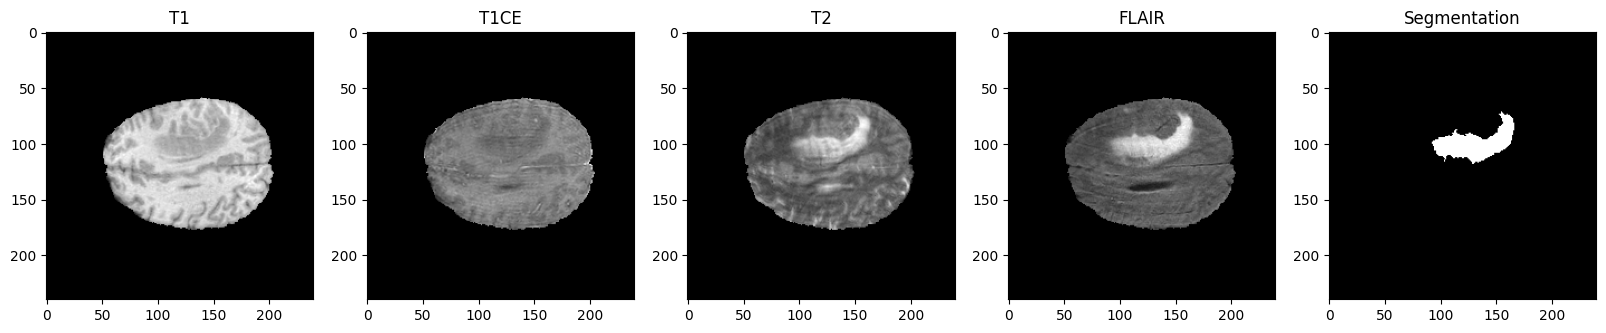

In [ ]:
# Specify a data path (using the first patient in the Training dataset)
patient_path = 'brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_'

# Load the 4 MRI modalities and the segmentation using the nibabel library
t1_image = nib.load(patient_path + 't1.nii')
t1ce_image = nib.load(patient_path + 't1ce.nii')
t2_image = nib.load(patient_path + 't2.nii')
flair_image = nib.load(patient_path + 'flair.nii')
seg_image = nib.load(patient_path + 'seg.nii')

# Get the image data
t1_data = t1_image.get_fdata()
t1ce_data = t1ce_image.get_fdata()
t2_data = t2_image.get_fdata()
flair_data = flair_image.get_fdata()
seg_data = seg_image.get_fdata()

# Plot the 100th slice of the 4 MRI modalities and the segmentation
slice_number = 100

fig, subplots = plt.subplots(1, 5, figsize=(20, 20))
subplots[0].imshow(t1_data[:, :, slice_number], cmap="gray")
subplots[0].set_title('T1')
subplots[1].imshow(t1ce_data[:, :, slice_number], cmap="gray")
subplots[1].set_title('T1CE')
subplots[2].imshow(t2_data[:, :, slice_number], cmap="gray")
subplots[2].set_title('T2')
subplots[3].imshow(flair_data[:, :, slice_number], cmap="gray")
subplots[3].set_title('FLAIR')
subplots[4].imshow(seg_data[:, :, slice_number], cmap="gray")
subplots[4].set_title('Segmentation')
plt.show()


As can be seen from the above images, the four modalities show different aspects of the same image. <br>
To enhance the precision of tumor analysis and confirm its presence or absence, experts often rely on these four modalities. <br>

In our artificial approach, opting for only two modalities, as opposed to four, holds promise as it can significantly mitigate the computational and memory demands associated with the segmentation task, resulting in improved speed and efficiency. This entails excluding the T1 modality, as its enhanced counterpart, T1ce, renders it redundant. Similarly, the exclusion of the T2 modality is motivated by the potential interference of fluid-containing regions with our predictive accuracy. These fluid regions are effectively addressed in the FLAIR version, which offers superior delineation of affected areas and, consequently, presents a more advantageous choice for our training purposes.

<b>Note</b>: In the first phase of this project, we will be building a simple CNN model which will utilize only one of the four different images(in particular, T1CE) for model training. In the later phase of the project, we will implement multimodal unet model, which will utilize all the data provided

### Segmentation Image

Now let's explore the segmentation image provided by the experts in detail

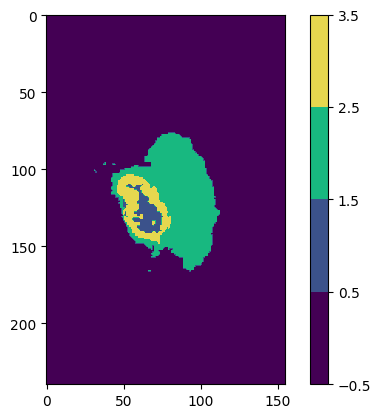

In [ ]:
# Specify the segmentation file path
seg_file_path = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii"
segmentation_data = nib.load(seg_file_path).get_fdata()

# Define a custom color map and normalization
custom_color_map = mpl.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
custom_norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], custom_color_map.N)

# Display the 100th slice of the segmentation data
plt.imshow(segmentation_data[100, :, :], cmap=custom_color_map, norm=custom_norm)
plt.colorbar()
plt.show()

In viewing the images across different planes, we observe that certain slices exhibit multiple colors (in this case, four colors), indicating that the experts have assigned multiple values to the segmentation. Let's examine the possible values within this dataset:

In [ ]:
dataset_directory = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
segmentation_files = [os.path.join(dataset_directory, sample, f"{sample}_seg.nii") for sample in os.listdir(dataset_directory) if not sample.endswith('.csv')]

max_unique_values_count = 0
max_unique_values = []

for seg_file in segmentation_files:
    segmentation_data = nib.load(seg_file).get_fdata()
    unique_values = np.unique(segmentation_data)
    unique_values_count = len(unique_values)

    if unique_values_count > max_unique_values_count:
        max_unique_values_count = unique_values_count
        max_unique_values = unique_values

print(f"Maximum number of unique values in all segmentation images: {max_unique_values_count}")
print(f"Corresponding values: {max_unique_values}")


Maximum number of values in all segmentation images: 4
Values: [0. 1. 2. 4.]


<p>
It's evident that we have four possible values in the segmentation files, each corresponding to one of the four classes. Here's the mapping: <br>
&emsp; 0: Not Tumor (NT) - Represents the Healthy Zone or Background <br>
&emsp;1: Necrotic and Non-Enhancing Tumor (NCR + NET) <br>
&emsp;2: Peritumoral Edema (ED) <br>
&emsp;4: Enhancing Tumor (ET) <br>

Notably, class 3 is absent, and we directly transition to class 4. We will rectify this "error" before feeding the data into our model. Our objective is to predict and segment these four classes for new patients, aiding in the diagnosis of brain tumors and identification of affected regions.
</p>

Now, let's examine the distribution of these four values:

In [ ]:
values, counts = np.unique(segmentation_image, return_counts=True)
print(counts)

[8716021   15443  168794   27742]



Let's explore the meaning of these four distinct classes by displaying them individually:

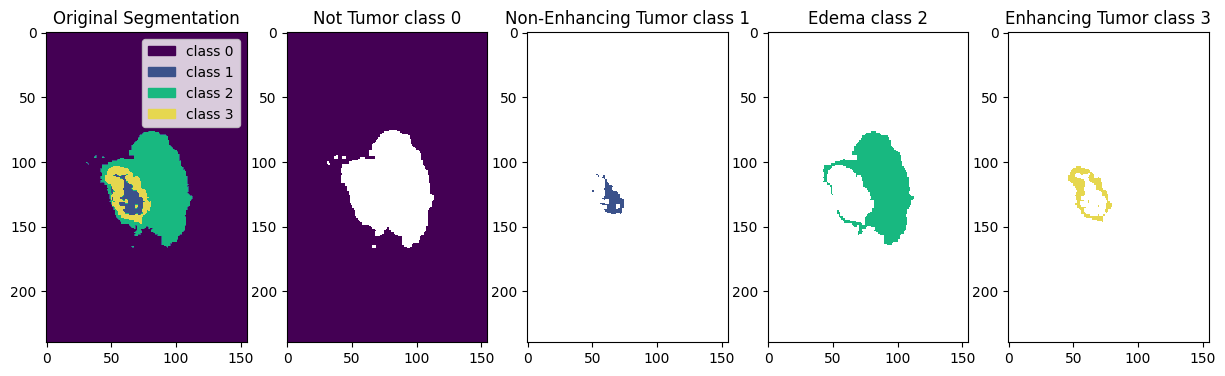

In [ ]:
# Deletion of class 0
class_0_segmentation = segmentation_image.copy()
class_0_segmentation[class_0_segmentation != 0] = np.nan

# Isolation of class 1
class_1_segmentation = segmentation_image.copy()
class_1_segmentation[class_1_segmentation != 1] = np.nan

# Isolation of class 2
class_2_segmentation = segmentation_image.copy()
class_2_segmentation[class_2_segmentation != 2] = np.nan

# Isolation of class 4
class_3_segmentation = segmentation_image.copy()
class_3_segmentation[class_3_segmentation != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 3']
legend = [plt.Rectangle((0, 0), 1, 1, color=color_map(i), label=class_names[i]) for i in range(len(class_names))]

fig, axis = plt.subplots(1, 5, figsize=(15, 15))

axis[0].imshow(segmentation_image[100, :, :], cmap=color_map, norm=norm)
axis[0].set_title('Original Segmentation')
axis[0].legend(handles=legend, loc='upper right')

axis[1].imshow(class_0_segmentation[100, :, :], cmap=color_map, norm=norm)
axis[1].set_title('Not Tumor class 0')

axis[2].imshow(class_1_segmentation[100, :, :], cmap=color_map, norm=norm)
axis[2].set_title('Non-Enhancing Tumor class 1')

axis[3].imshow(class_2_segmentation[100, :, :], cmap=color_map, norm=norm)
axis[3].set_title('Edema class 2')

axis[4].imshow(class_3_segmentation[100, :, :], cmap=color_map, norm=norm)
axis[4].set_title('Enhancing Tumor class 3')

plt.show()


### Summary of Exploratory Data Analysis:

&emsp; 1. For each sample or patient, we have four distinct modalities (T1, T1CE, T2, and FLAIR), each accompanied by a segmentation map that delineates tumor areas. <br>

&emsp; 2.
T1CE and FLAIR modalities are the most valuable to retain, as these two modalities offer complementary insights into the patient's brain anatomy and tissue contrast. <br>

&emsp; 3. A segmentation image contains 4 classes. <br>

&emsp; 4. Class 4 must be changed to class 3, since it was missing in the original dataset. <br>

&emsp; 5. Class 0 was over-represented. So, to reduce it, we can crop the image

## <b>Data Preprocessing</b>

### Splitting the dataset into 3 sets

Although the BraTS dataset contains separate folders for Training Data and Validation Data, it does not contain segmented data and, as a result, cannot be utilized. Hence, we will disregard the samples within this folder and establish our own validation set.






We will divide the Training Data into three sets: <b>Training, Validation and Test</b>

First, before dividing the training data, we need to remove two .csv files that are present along with the training data.

In [ ]:
# Define selected slices range
VOLUME_START_AT = 60
VOLUME_SLICES = 75


In [ ]:
dataset_path = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
data_entries = os.listdir(dataset_path)
data_entries.remove("survival_info.csv")
data_entries.remove("name_mapping.csv")

Now, lets create three different sets:

In [ ]:
# Split the dataset into training and validation sets
training_set, validation_set = train_test_split(data_entries, test_size=0.2, random_state=42)

# Split the training set into the actual training set and a testing set
training_set, testing_set = train_test_split(training_set, test_size=0.15, random_state=42)

# Print data distribution (Training: 68%, Testing: 12%, Validation: 20%)
print(f"Training set length: {len(training_set)}")
print(f"Validation set length: {len(validation_set)}")
print(f"Test set length: {len(testing_set)}")


Training set length: 250
Validation set length: 74
Test set length: 45


### Creating a DataGenerator

To train a neural network for image segmentation, it's essential to provide both the raw image data (X) and the ground truth segmentations (y). Combining these two types of data allows the neural network to learn tumor patterns and make accurate predictions from patient scans.

However, it's not feasible to send our modality images (X) and segmentations (y) directly to the AI model due to memory constraints. Loading all these 3D images would overwhelm the system's memory and potentially lead to shape mismatch errors. Therefore, we need to perform image preprocessing using a Data Generator. Within this Data Generator, we'll execute the necessary operations when loading the images for each sample:

1. Retrieve the paths of the files (T1CE in particular, as it provides complementary information about brain anatomy and tissue contrast).
Retrieve the path of the ground truth (original segmentation).
2. Load the files and segmentation.
3. Create a y array containing selected slices from the segmentation.
4. Assign a value of 3 to all instances in the mask array to address the three missing cases mentioned earlier.
5. These preprocessing steps will enable us to efficiently prepare the data for training the neural network.






Code for DataGenerator is given below(for baseline U-Net architecture)

In [ ]:
IMAGE_SIZE = 128

class CustomDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, ids_list, dimensions=(IMAGE_SIZE, IMAGE_SIZE), batch_size=1, channels=2, shuffle=True):
        'Initialization'
        self.dimensions = dimensions  # Resized image dimensions (128 x 128)
        self.batch_size = batch_size  # Number of images to load each time
        self.ids_list = ids_list  # Patients IDs
        self.channels = channels  # Number of channels (T1CE + FLAIR)
        self.shuffle = shuffle  # Indicates if data is shuffled for each epoch
        self.on_epoch_end()  # Updates indexes after each epoch

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.ids_list) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        batch_ids = [self.ids_list[k] for k in indexes]

        # Load & Generate data
        X, y = self.__data_generation(batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.ids_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dimensions, self.channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))

        # Generate data
        for c, i in enumerate(batch_ids):

            # Get path of each RMI modality and the segmentation
            sample_path = os.path.join(data_path, i, i)
            t1ce_path = sample_path + '_t1ce.nii'
            # flair_path = sample_path + '_flair.nii'
            seg_path = sample_path + '_seg.nii'
            #t1_path = sample_path + '_t1.nii'
            #t2_path = sample_path + '_t2.nii'

            # Extract the data from these paths
            t1ce = nib.load(t1ce_path).get_fdata()
            # flair = nib.load(flair_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()
            #t1 = nib.load(t1_paths).get_fdata()
            #t2 = nib.load(t2_path).get_fdata()

            for j in range(VOLUME_SLICES):
                #  X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMAGE_SIZE, IMAGE_SIZE))
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(t1ce[:, :, j + VOLUME_START_AT], (IMAGE_SIZE, IMAGE_SIZE))

                y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]

        # Masks / Segmentations
        y[y == 4] = 3
        mask = tensorflow.one_hot(y, 4)
        Y = tensorflow.image.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))

        # Scale data between 0 and 1 (since the minimum value in the data is 0)
        return X / np.max(X), Y

training_generator = CustomDataGenerator(training_set)
validation_generator = CustomDataGenerator(validation_set)
testing_generator = CustomDataGenerator(testing_set)


### Summary of above preprocessing steps is given below:

1. We employ a data generator to facilitate the processing and delivery of our data to the neural network, given that it's not feasible to store all our images in memory simultaneously.



2. For each epoch (a single pass of the entire training dataset through the neural network), the model will be provided with 250 samples from our training dataset.

3. For each sample, the model will analyze 75 slices, and these slices will be received in a (128, 128) shape. This data will be structured as an X array with a shape of (128, 128, 75, 2). Additionally, the model will be provided with the ground truth segmentation of the patient, which will be One-Hot encoded and have a shape of (75, 128, 128, 4).

## <b>Model Definition</b>

U-Net based basic CNN model

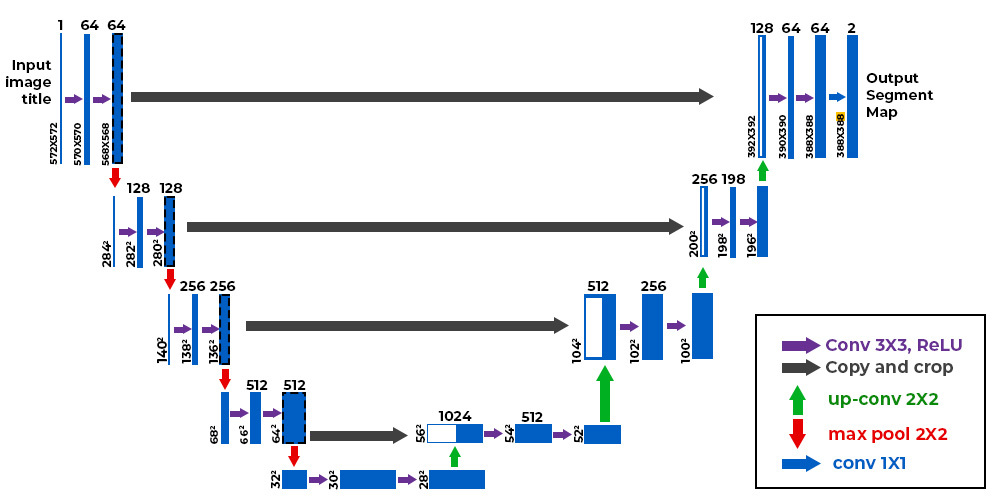

This above image shows the design of a baseline U-Net architecture. Below given is the code for its implementation

In [ ]:
def baseline_unet(inputs, initial_kernel, dropout):
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=initial_kernel)(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=initial_kernel)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initial_kernel)(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initial_kernel)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=initial_kernel)(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=initial_kernel)(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=initial_kernel)(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=initial_kernel)(conv4)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=initial_kernel)(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=initial_kernel)(conv5)
    drop1 = Dropout(dropout)(conv5)

    up1 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=initial_kernel)(UpSampling2D(size=2)(drop1))
    merge1 = concatenate([conv3, up7], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=initial_kernel)(merge1)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=initial_kernel)(conv7)

    up2 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=initial_kernel)(UpSampling2D(size=2)(conv7))
    merge2 = concatenate([conv2, up8], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=initial_kernel)(merge2)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=initial_kernel)(conv7)

    up3 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=initial_kernel)(UpSampling2D(size=2)(conv7))
    merge3 = concatenate([conv, up9], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initial_kernel)(merge3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initial_kernel)(conv8)

    up4 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=initial_kernel)(UpSampling2D(size=2)(conv8))
    merge4 = concatenate([conv1, up], axis=3)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=initial_kernel)(merge4)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=initial_kernel)(conv9)

    conv10 = Conv2D(4, 1, activation='softmax')(conv9)

    return Model(inputs=inputs, outputs=conv10)


## <b>Defining Metrics</b>

In [ ]:
def calculate_dice_coefficient(y_true, y_pred, smoothing=1.0):
    num_classes = 4
    for i in range(num_classes):
        true_flat = K.flatten(y_true[:, :, :, i])
        pred_flat = K.flatten(y_pred[:, :, :, i])
        intersection = K.sum(true_flat * pred_flat)
        loss = ((2. * intersection + smoothing) / (K.sum(true_flat) + K.sum(pred_flat) + smoothing))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / num_classes
    return total_loss

def calculate_precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_value = true_positives / (predicted_positives + K.epsilon())
    return precision_value

def calculate_sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def calculate_specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

## <b>Building the Model</b>

In [ ]:
# Define the shape of input data
input_data_shape = Input((IMG_SIZE, IMG_SIZE, 2))

# Build and compile the neural network model
model1_baseline_unet = baseline_unet(input_data_shape, 'he_normal', dropout_rate=0.2)

model1_baseline_unet.compile(
    loss="categorical_crossentropy",
    optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy', tensorflow.keras.metrics.MeanIoU(num_classes=4), calculate_dice_coefficient, calculate_precision, calculate_sensitivity, calculate_specificity]
)


## <b>Defining Callback Functions</b>

We have also written some callback functions that will be executed during the training process. These are as follows:

1. <b>AlterLROnPlateau:</b> This function curtails the learning rate if a specified metric (like validation loss) ceases to show improvement. The decrement factor is 0.2, patience spans 2 epochs, and the lower limit for the learning rate is established at 0.000001.

2. <b>ModelCheckpoint:</b> : It ensures that the best model weights (the one with the lowest validation loss during epochs) are saved. This allows us to reuse or share the model without the need for a complete retraining, saving both time and resources!

3. <b>CSVLogger: </b>: It appends metrics to a CSV file named training.log. It records these metrics, and if the file already exists, it is overwritten (since the append parameter is set to False). This functionality aids in tracking and analyzing the training progress throughout different epochs

In [ ]:
custom_callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),

    keras.callbacks.ModelCheckpoint(filepath='model_checkpoint.{epoch:02d}-{val_loss:.6f}.h5',
                             verbose=1, save_best_only=True, save_weights_only=True),

    CSVLogger('training_records.log', separator=',', append=False)
]


## <b>Training the Model</b>

In [ ]:

model1.fit(training_generator,
          epochs=25,
          steps_per_epoch=len(train_set),
          callbacks=custom_callbacks,
          validation_data=validation_generator)

Epoch 1/25
250/250 [==============================] - ETA: 0s - loss: 0.0881 - accuracy: 0.9802 - mean_io_u: 0.6263 - dice_coef: 0.2715 - precision: 0.9801 - sensitivity: 0.9800 - specificity: 0.9934
Epoch 1: val_loss improved from inf to 0.07620, saving model to model_.01-0.076196.m5
250/250 [==============================] - 158s 633ms/step - loss: 0.0881 - accuracy: 0.9802 - mean_io_u: 0.6263 - dice_coef: 0.2715 - precision: 0.9801 - sensitivity: 0.9800 - specificity: 0.9934 - val_loss: 0.0762 - val_accuracy: 0.9838 - val_mean_io_u: 0.4023 - val_dice_coef: 0.2695 - val_precision: 0.9836 - val_sensitivity: 0.9836 - val_specificity: 0.9945 - lr: 0.0010
Epoch 2/25
250/250 [==============================] - ETA: 0s - loss: 0.0797 - accuracy: 0.9804 - mean_io_u: 0.6205 - dice_coef: 0.2883 - precision: 0.9808 - sensitivity: 0.9797 - specificity: 0.9936
Epoch 2: val_loss improved from 0.07620 to 0.06263, saving model to model_.02-0.062625.m5
250/250 [==============================] - 158s 

### <b> Analysis of the Model</b>

Once the model has been trained, we will now do some analysis of our model to see how it performed on training and validation data.

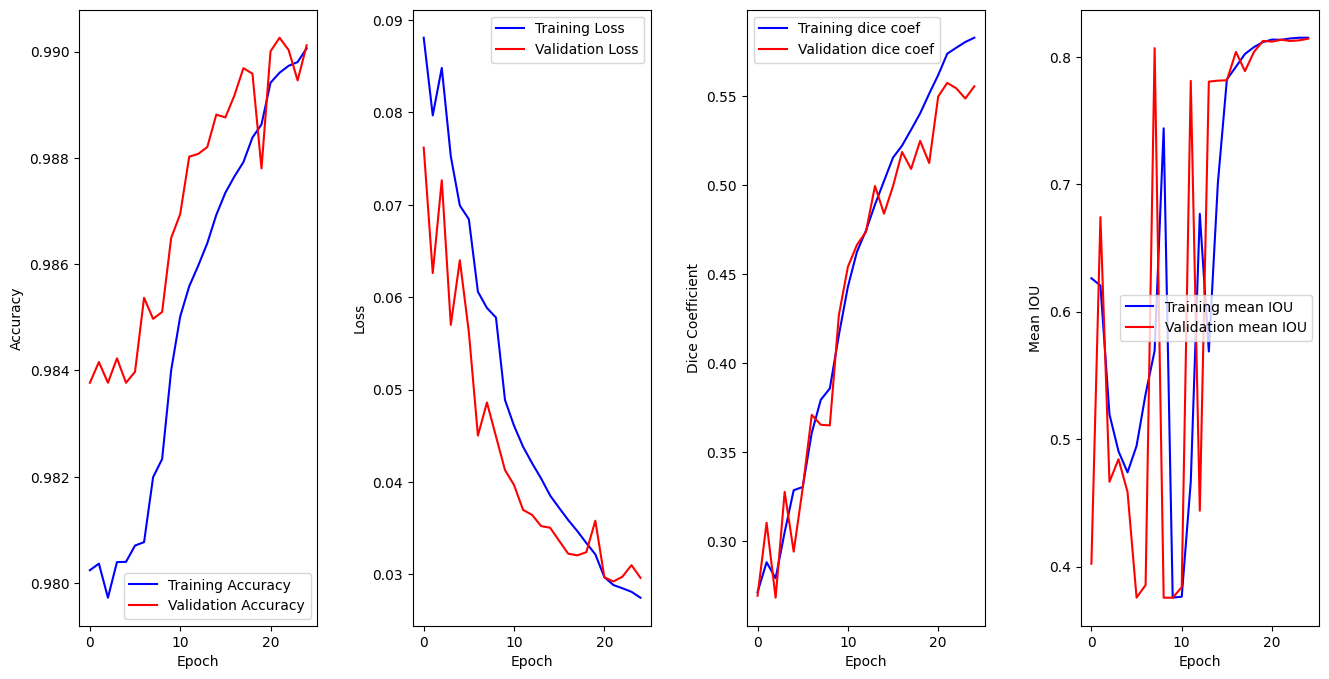

In [ ]:
# Load the CSV logger file containing training metrics (accuracy, loss, dice_coef, etc.)
training_history = pd.read_csv('training.log', sep=',', engine='python')

# Plot training and validation metrics
figure, axes = plt.subplots(1, 4, figsize=(16, 8))

axes[0].plot(training_history['epoch'], training_history['accuracy'], 'b', label='Training Accuracy')
axes[0].plot(training_history['epoch'], training_history['val_accuracy'], 'r', label='Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['epoch'], training_history['loss'], 'b', label='Training Loss')
axes[1].plot(training_history['epoch'], training_history['val_loss'], 'r', label='Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

axes[2].plot(training_history['epoch'], training_history['dice_coef'], 'b', label='Training Dice Coef')
axes[2].plot(training_history['epoch'], training_history['val_dice_coef'], 'r', label='Validation Dice Coef')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Dice Coefficient')
axes[2].legend()

axes[3].plot(training_history['epoch'], training_history['mean_io_u'], 'b', label='Training Mean IOU')
axes[3].plot(training_history['epoch'], training_history['val_mean_io_u'], 'r', label='Validation Mean IOU')
axes[3].set_xlabel('Epoch')
axes[3].set_ylabel('Mean IOU')
axes[3].legend()

# Adjust space between subplots
plt.subplots_adjust(wspace=0.4)

plt.show()


In the accuracy graph, there's a clear upward trend in both training and validation accuracy across epochs, eventually stabilizing. This suggests that our model effectively learns from the data and generalizes well to new instances. Notably, there's no apparent overfitting concern, as both metrics show improvement.

Observing the loss graph, it's evident that our model is indeed learning from the training data, with both training and validation losses consistently decreasing. The optimal model version seems to be achieved around epoch 20, as indicated in the training logs. This observation is further supported by the subsequent graph, illustrating a progressive increase in dice coefficients throughout epochs.

## <b>Model Prediction On Unseen Data</b>

Now, since all the analysis has been done and our model has performed quite well, we will now feed our model with some unseen data and see how well it is performing on them.

The code given below will be used for segmentation purpose.

In [ ]:
def perform_segmentation_prediction(patient_path):
    # Load NIfTI (.nii) files of the patient
    t1ce_filepath = patient_path + '_t1ce.nii'
    flair_filepath = patient_path + '_flair.nii'

    # Extract the data from these paths
    t1ce_data = nib.load(t1ce_filepath).get_fdata()
    flair_data = nib.load(flair_filepath).get_fdata()

    # Create an empty array
    input_data = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    # Process the data to match the input shape of the CNN model
    for slice_index in range(VOLUME_SLICES):
        input_data[slice_index, :, :, 0] = cv2.resize(flair_data[:, :, slice_index + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        input_data[slice_index, :, :, 1] = cv2.resize(t1ce_data[:, :, slice_index + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    # Normalize and send the images to the CNN model for segmentation prediction
    normalized_input = input_data / np.max(input_data)
    return model1.predict(normalized_input, verbose=1)


In [ ]:
def display_predicted_segmentations(sample_list, slice_index, colormap, normalization):
    # Choose a random patient
    selected_sample = random.choice(sample_list)

    # Get the path of this patient
    sample_path = os.path.join(data_path, selected_sample, selected_sample)

    # Predict the segmentation for the patient
    predicted_segmentation = predict_segmentation(sample_path)

    # Load the original segmentation (Ground truth) for the patient
    segmentation_path = sample_path + '_seg.nii'
    original_segmentation = nib.load(segmentation_path).get_fdata()

    # Resize the original segmentation to match the dimensions of the predictions
    original_segmentation = cv2.resize(original_segmentation[:, :, slice_index + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    # Differentiate segmentations by their labels
    all_layers = predicted_segmentation[slice_index, :, :, 1:4]  # Exclude class 0 (Background), keeping Core, Edema, Enhancing classes
    background_layer = predicted_segmentation[slice_index, :, :, 0]  # Isolate class 0, Background
    core_layer = predicted_segmentation[slice_index, :, :, 1]  # Isolate class 1, Core
    edema_layer = predicted_segmentation[slice_index, :, :, 2]  # Isolate class 2, Edema
    enhancing_layer = predicted_segmentation[slice_index, :, :, 3]  # Isolate class 3, Enhancing

    # Plot Original segmentation & predicted segmentation
    print("Patient ID: ", selected_sample)
    fig, ax_array = plt.subplots(1, 6, figsize=(25, 20))

    # Original segmentation
    ax_array[0].imshow(original_segmentation, colormap, normalization)
    ax_array[0].set_title('Original Segmentation')

    # Layers 1, 2, 3
    ax_array[1].imshow(all_layers)
    ax_array[1].set_title('Predicted Segmentation - all layers')

    # Layer 0
    ax_array[2].imshow(background_layer)
    ax_array[2].set_title('Predicted Segmentation - layer 0')

    # Layer 1
    ax_array[3].imshow(core_layer)
    ax_array[3].set_title('Predicted Segmentation - layer 1')

    # Layer 2
    ax_array[4].imshow(edema_layer)
    ax_array[4].set_title('Predicted Segmentation - layer 2')

    # Layer 3
    ax_array[5].imshow(enhancing_layer)
    ax_array[5].set_title('Predicted Segmentation - layer 3')

    # Adjust space between subplots
    plt.subplots_adjust(wspace=0.8)

    plt.show()


3/3 [==============================] - 4s 569ms/step
Patient number:  BraTS20_Training_256


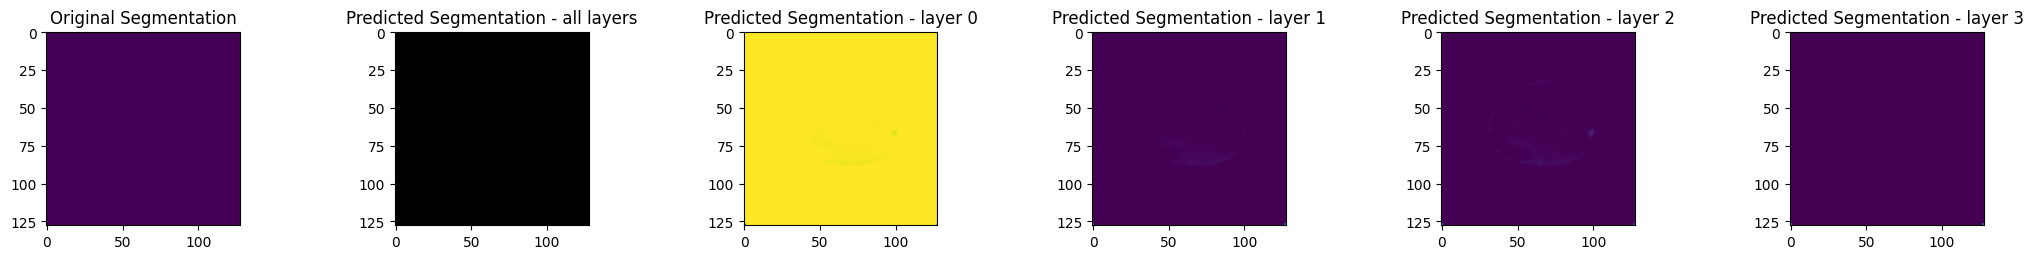

In [ ]:
display_predicted_segmentations(test_set, 60, color_map, norm)

3/3 [==============================] - 0s 71ms/step
Patient number:  BraTS20_Training_172


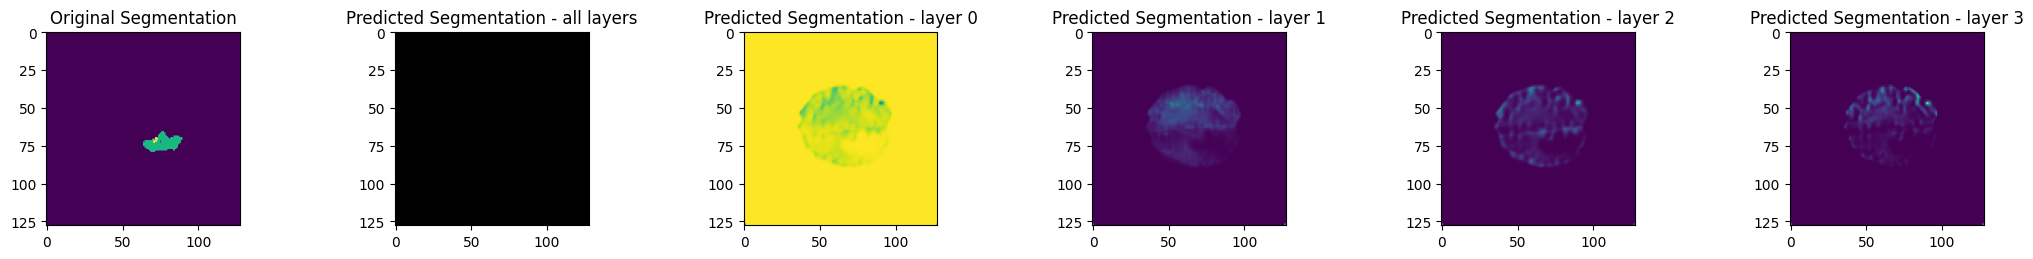

In [ ]:
display_predicted_segmentations(test_set, 50, color_map, norm)

3/3 [==============================] - 0s 71ms/step
Patient number:  BraTS20_Training_016


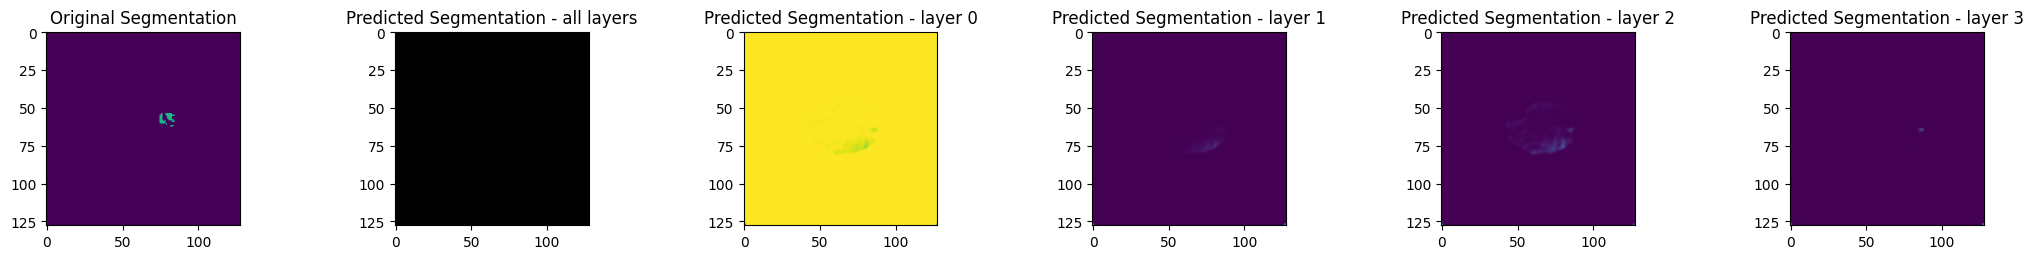

In [ ]:
display_predicted_segmentations(test_set, 70, color_map, norm)

3/3 [==============================] - 0s 71ms/step
Patient number:  BraTS20_Training_104


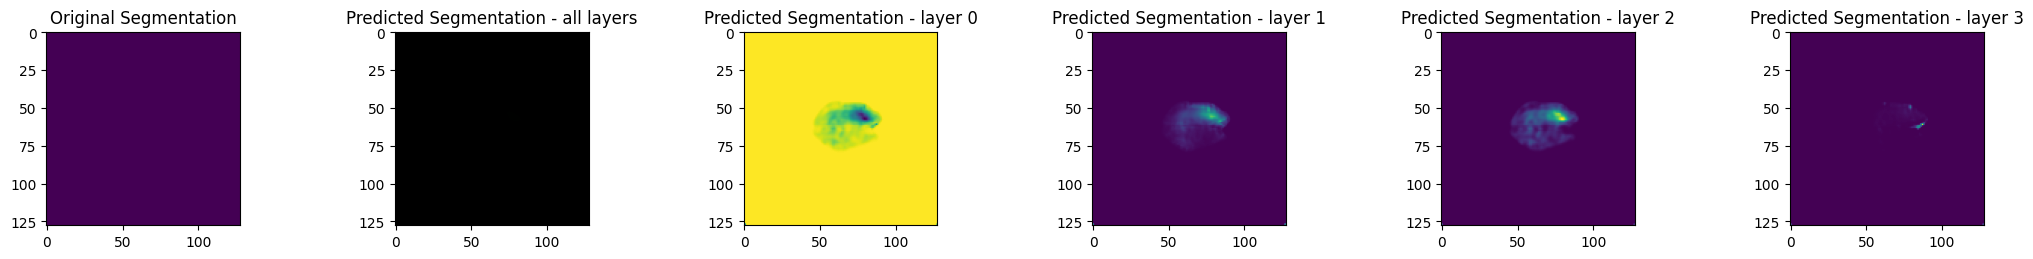

In [ ]:
display_predicted_segmentations(test_set, 70, color_map, norm)

3/3 [==============================] - 0s 71ms/step
Patient number:  BraTS20_Training_227


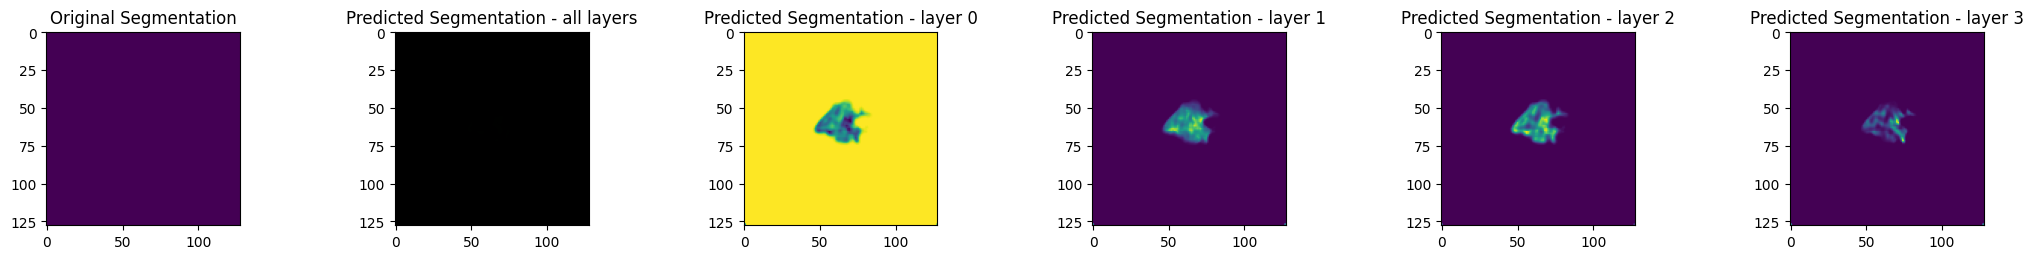

In [ ]:
display_predicted_segmentations(test_set, 70, color_map, norm)

As can be seen from the above result, the model is performing quite well on unseen data.

But still, there are some samples for which it is predicting tumors, when there are none(4th plot, patient 104, slice 70).




In medical fields,these errors can't be tolerated. So, we still need to work on our model to improve its accuracy. This is what we will do in the later phase of this project. We have planeed to implement multimodal unet based cnn model, which will utilize all the MRI information of a patient to give predictions.

## <b>Model Evaluation</b>

In [ ]:
evaluation_results = model1.evaluate(test_generator, batch_size=100, callbacks=callbacks)

metric_descriptions = ["Loss", "Accuracy", "MeanIOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity"]

# Pair up results with their corresponding descriptions
result_description_pairs = zip(evaluation_results, metric_descriptions)

# Displaying each metric with its respective description
print("\nEvaluation Results on the Test Set:")
print("===================================")
for index, (metric_result, metric_description) in enumerate(result_description_pairs):
    print(f"{metric_description} : {round(metric_result, 4)}")


45/45 [==============================] - 13s 277ms/step - loss: 0.0333 - accuracy: 0.9886 - mean_io_u: 0.8159 - dice_coef: 0.5857 - precision: 0.9896 - sensitivity: 0.9868 - specificity: 0.9965

Model evaluation on the test set:
Loss : 0.0333
Accuracy : 0.9886
MeanIOU : 0.8159
Dice coefficient : 0.5857
Precision : 0.9896
Sensitivity : 0.9868
Specificity : 0.9965
